# Searching for Exoplanet (Candidates) with TIKE

<a class="anchor" id="learning_objectives"></a>
## Learning objectives 

- Rapidly access large amounts of TESS data on the cloud
- Search for transits in the large TESS data collections
- Perform multithreading operations on TIKE

## Table of Contents
 * [Introduction](#Introduction)
     * [Import packages, set constants](#Import-packages,-set-constants)
 * [2. Find stars](#2._find_stars)
 * [Next: aggregate all the lightcurves!](#next:_aggregate_all)
 * [Next: search the lightcurves for planets.](#next:_search_the)
	 * [About this notebook](#about_this_notebook)

## Introduction
Studying exoplanet demographics (the frequency of different types of exoplanets) lets us tackle some of the biggest questions in exoplanet science: How do planets form? How do they evolve? Are there any exoplanets that are like the Earth? 

TIKE is an excellent resource for computing occurrence rates, since:

- file access is fast; your code runs in a data center with a copy of MAST data
- you don't need to download data to your own computer, saving your local storage 
- you don't have to use your own computational resources
- in most cases, the scientific computing environments are already set up: you don't need to spend time wrangling environments.


In this notebook, we'll take one of the first major steps to calculating occurrence rates: searching a large selection of lightcurves for exoplanets. 

**Note:** our abridged version may produce spurious planetary candidates! While we favor a concise narrative and rapid notebook execution time here, we'll note when applicable where a more robust approach should be taken for, e.g., a scientific publication.

### Import packages

Before diving into planet-finding, we will import some necessary packages.

- `astropy` contains a number of utility functions for working with astronomical data.
- `astroquery` lets us easily query the astronomical databases that contain the TESS lightcurves.
- `numpy` is used for array manipulation.
- `matplotlib.pyplot` is used to display images and plot datasets.
- `tqdm` is a lightweight progress bar that we can use to track how long our calculations will take.
- `pandas` let us interact easily with CSV files that we'll be downliading.
- `os` and `concurrent` let us make informed choiced when multithreading.

In [1]:
!pip install -U --pre astroquery

  Using cached astroquery-0.4.8.dev9474-py3-none-any.whl.metadata (7.3 kB)
Using cached astroquery-0.4.8.dev9474-py3-none-any.whl (5.4 MB)
  Attempting uninstall: astroquery
    Found existing installation: astroquery 0.4.7
    Uninstalling astroquery-0.4.7:
      Successfully uninstalled astroquery-0.4.7


In [2]:
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

We'll also make sure that we retrieve cloud files from AWS, making our data access much faster.

In [3]:
# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


### Set Constants
We'll now set a few physical constants and conversion factors so that we can use them later on.

In [4]:
G = const.G.si.value
days_to_seconds = (u.day).to(u.s)
r_earth_to_meters = (u.R_earth).to(u.m)
m_sun_kg = (u.M_sun).to(u.kg)
r_sun_m = (u.R_sun).to(u.m)

## Query for Host Stars

Generally, the first step to finding planets is figuring out which host stars you want to search for orbiting planets. In this study, we want to find the occurrence of hot Jupiters around Sun-like stars. We'll make some cuts so that we're looking for bright, high-gravity, solar-mass stars:

- *bright*: TESS was designed to look for transits around bright, nearby stars. These stars' TESS data will have high signal to noise ratios, so we have better chances of finding planetary signals in them.
- *high-gravity*: particularly low-gravity stars tend to be evolved off the stellar main-sequence, and therefore not very Sun-like.
- *solar-mass*: solar-mass stars on the stellar main sequence tend to be quite solar.

To find these stars, we'll query the TESS Candidate Target List (CTL) — a list of stars pre-selected by the TESS team to be likely good targets for transit detection (i.e., bright, low flux contamination).

In [5]:
# this cell will take ~30 seconds to run
catalog_data = Catalogs.query_criteria(catalog="Ctl",
                                       Tmag=[0, 10.5], # remember, lower magnitudes are brighter than higher ones!
                                       logg=[4.1,400], # solar logg ~ 4.4
                                       mass=[0.8, 1.05]) # these masses are in solar radii

Let's take a look at this catalog data.

In [6]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str10
257486953,20190415,--,0004-01211-1,470-000036,00012257+0348137,1237678660350443525,J000122.66+034813.6,2740122790489701376,36101679,--,STAR,tmgaia2,0.344014992249018,3.80382001946707,tmgaia2,146.948,0.0785775,-2.18292,0.0365631,gaia2,8.86194,0.0507367,gaia2,99.6790809499965,-56.7907190407385,1.83033674668151,3.35274204776744,11.505,0.143,10.942,0.01,14.3561,0.00539245,11.5687,0.000667307,10.7394,0.000559878,10.5503,0.000599356,12.8011,0.0102534,9.525,0.026,9.107,0.024,9.042,0.021,AAA-222-111-000-0-0,nan,8.983,0.023,9.047,0.019,9.005,0.033,8.635,0.379,10.6881,0.00022,10.1918,0.006,rered,spect,5341.65,143.697,4.54113,0.0907658,-0.201,0.015,0.853239,0.0557889,0.923,0.117416,1.4859,0.389627,DWARF,0.5339956,0.01659735,112.48,0.647,0.0101352,0.0038456,27,0.03483629,--,--,0.0,0.00244247,0.00524873,panstarrs,0.10486,0.129972,0.0621553,0.0494226,0.31747,0.461784,0.0833452,0.0981863,0.0125266,0.0206681,0.643,0.651,bj2018,150.666,136.728,spect,11.0949,0.000455,10.1404,0.000426,1,--,tycho2v3,tycho2b3,planetcandidate,1.21935322296911,0.567092439365747,0.34464908190135,3.80381062101592,0.0422055151724629,0.0203261439774303,1,0,95867
388583226,20190415,--,4500-00124-1,849-000014,00004121+7940398,--,J000041.30+794039.9,564638150446547200,60652017,--,STAR,tmgaia2,0.171723066040282,79.6777485493965,tmgaia2,23.2049,0.0463689,0.752656,0.0441405,gaia2,6.3842,0.0331064,gaia2,120.572822336236,17.0392128647769,65.4255217247576,64.4779480185437,11.001,0.072,10.244,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.922,0.027,8.612,0.033,8.523,0.021,AAA-122-111-000-0-0,nan,8.454,0.022,8.48,0.02,8.395,0.022,8.311,0.211,10.0725,0.001459,9.6085,0.0083,rered,gaia2,5655.0,121.218,4.14638,0.0746591,nan,nan,1.39908,0.066985,1.0,0.125138,0.365152,0.0760686,DWARF,1.80347264,0.0588778,155.936,0.811,0.0217066,0.008248645,157,0.0207567867,--,--,0.0025412635165229,0.00913321,0.00736408,panstarrs,0.0875932,0.162682,0.079991,0.0539789,0.0629468,0.0891903,0.074668,0.0746503,0.0552031,0.0625525,0.807,0.815,bj2018,134.725,107.712,dered,10.4504,0.004713,9.56295,0.00391,1,--,tycho2v3,tycho2b3,planetcandidate,0.936393976453562,0.684649721171938,0.172280648286862,79.677751790477,0.0266482483131485,0.02541745671

This is a pretty long table, totaling 53056 stars, with many columns of information about each star.

### Get Data from Example Star

To get a better sense of the data products we'll be working with, let's access a single lightcurve associated with one of these stars.

In [7]:
# fixing a target ID for reproducibility. we promise it's in the table above!
example_id = 257486953

# bundle our query into one line that produces an S3 URI: the cloud file location
lc_uri = Observations.get_cloud_uris(target_name=example_id
                                     , obs_collection="TESS"
                                     , dataproduct_type="timeseries"
                                     , filter_products={
                                         "productType":"SCIENCE", 
                                         "productSubGroupDescription":"LC"
                                         }
                                    )

# open the S3 file
lc_fits = fits.open(lc_uri[0], use_fsspec=True, fsspec_kwargs={"anon": True})

/opt/conda/envs/tess/lib/python3.11/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Great! This file is now loaded as `lc_fits`. Now, let's examine the columns available to us in this lightcurve.

In [8]:
# HDU 1 is the lightcurve HDU. run lc_fits.info() to see all HDUs
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

There are two flux columns: SAP flux and PDCSAP flux. The SAP flux is closer to raw TESS data. The PDCSAP_FLUX is derived from SAP flux, but it's been cleaned of longer-term trends.

### Plot Data from Example Star

Let's plot both types of flux to get a sense of their differences.

Text(0.5, 0, 'TIME  (BJD-2457000)')

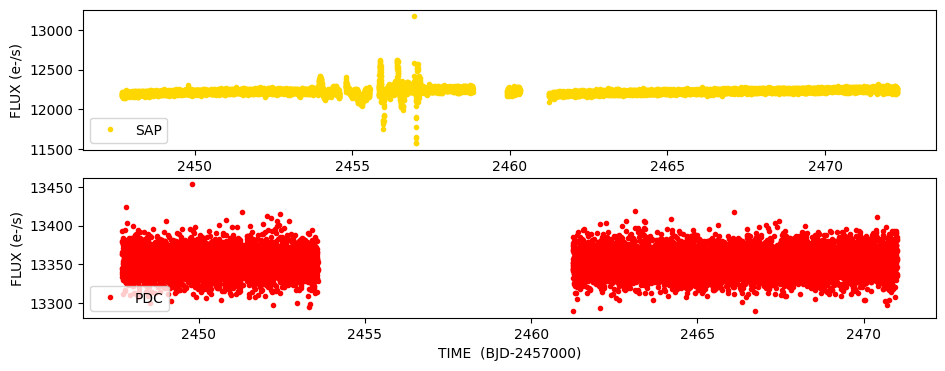

In [10]:
# convenience variables for our fluxes
sapflux = lc['SAP_FLUX']
pdcflux = lc['PDCSAP_FLUX']
time_lc = lc['TIME']

# set up the figure
fig = plt.figure(figsize = (11,4))

# create plot for SAP flux
fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

# create plot for PDCSAP flux
fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

Text(0.5, 0, 'TIME  (BJD-2457000)')

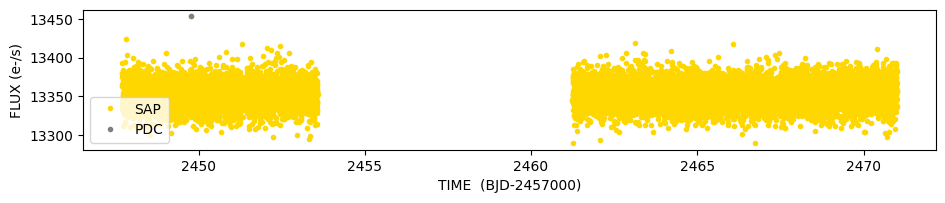

In [11]:
# convenience variables for our fluxes
sapflux = lc['SAP_FLUX']
pdcflux = lc['PDCSAP_FLUX']
time_lc = lc['TIME']
quality = lc['QUALITY']

# set up the figure
fig = plt.figure(figsize = (11,4))

# create plot for SAP flux
fig.add_subplot(211)
plt.plot(time_lc, pdcflux,'.', label = 'SAP', color = "gold")
# plt.legend(loc = 'lower left')
# plt.ylabel("FLUX (e-/s)")


# Locate quality flags greater than zero.
where_gt0 = np.where(quality > 0)[0]

# Apply mask to time and flux arrays
time_lc_good = time_lc[where_gt0]
pdcflux_good = pdcflux[where_gt0]

# create plot for PDCSAP flux
# fig.add_subplot(212)
plt.plot(time_lc_good, pdcflux_good,'.', label = 'PDC', color = "gray", zorder=200)
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

# overplot the bad flags?

In [12]:
time_lc_good

array([2447.6903333 , 2447.69172227, 2447.69311124, ..., 2473.16202178,
       2473.16341069, 2473.16479961], dtype='>f8')

This definitely looks like a TESS lightcurve! The PDC data, as expected, are smoother and have instrumental effects removed.

## Aggregate All Light Curves

Now we know how to access a single lightcurve. To calculate our occurrence rates, we'll need to download lightcurves from many stars. 

The neatest way to do this is to write a function that accesses TESS lightcurves, then loop over that function for all the stars we want to query. Along the way, we'll incorporate a few tricks to speed things up.

Instead of saving the data as files, it's more efficient to keep all of this data in RAM as we go. A neat way to do this is to define a class for our data, fetch the data with a method of that class, then assign the data to an attribute of that class. This object-oriented approach avoids extra input/output (I/O) time and maintains clean code design.

In [13]:
class LightcurveData:
    def __init__(self, catalog_id):
        """
        Initializes the instance.
        """
        self.catalog_id = catalog_id # assign catalog ID to the object

    def fetch_and_save_data(self):
        """
        Accesses and saves data from a TESS target.
    
        Inputs
        ------
            :catalog_id: (int) TESS Input Catalog (TIC) ID.
        """
        
        
        lc_uri = Observations.get_cloud_uris(target_name=self.catalog_id
                                     , obs_collection="TESS"
                                     , dataproduct_type="timeseries"
                                     , filter_products={
                                         "productType":"SCIENCE", 
                                         "productSubGroupDescription":"LC"
                                         }
                                    )
        if lc_uri:
            # open the lc file
            lc_fits = fits.open(lc_uri[0], use_fsspec=True, fsspec_kwargs={"anon": True})
            
            # assign the data to this instance 
            lc = lc_fits[1].data
            quality = lc['QUALITY']
            high_quality = np.where(quality <= 0)[0]
            self.pdcflux = lc['PDCSAP_FLUX'][high_quality] #PDCSAP flux column
            self.pdcflux_err = lc['PDCSAP_FLUX_ERR'][high_quality] # flux error column
            self.time_lc = lc['TIME'][high_quality] #time column

        else:
            self.pdcflux = np.nan
            self.pdcflux_err = np.nan
            self.time_lc = np.nan

Let's test this method out on our example star from earlier.

In [14]:
lightcurvedata = LightcurveData(example_id)
lightcurvedata.fetch_and_save_data()

Let's check that this function worked correctly by checking that the method performed as expected.

Text(0.5, 0, 'TIME  (BJD-2457000)')

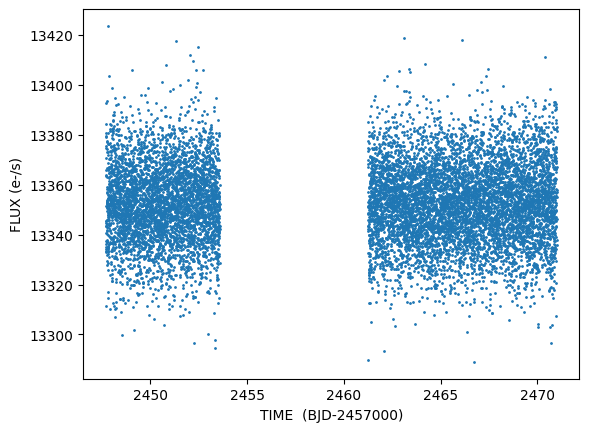

In [15]:
plt.scatter(lightcurvedata.time_lc, lightcurvedata.pdcflux, s=1)
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

Great! Our data has been downloaded and assigned as an attribute to an object.

### Parallel Computing
Now, we want to *parallelize* our computation. What this means is we want to access multiple lightcurve files simultaneously.

We'll use this with the Python [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) package to perform multithreading. Multithreading is a very [rich and complex subject](https://www.geeksforgeeks.org/multithreading-python-set-1/) — for our purposes, we can just think of it as splitting up our machine into different sections that each perform a separate task. Because our option is largely limited by remote server wait time, multithreading is a good parallelization choice.

Users typically have acess to 4 cores on TIKE, as of this document's last update. We can check the exact number below.

In [16]:
os.cpu_count() 

4

Now for a short function that will create an object for a catalog ID, download the data, and return the *object*. We'll have this function return both the TIC ID and the object itself so that it can be sorted even if we work through our catalog asynchronously.

In [17]:
def return_object(catalog_id):
    lightcurvedata = LightcurveData(catalog_id)
    lightcurvedata.fetch_and_save_data()
    return catalog_id, lightcurvedata

In [18]:
l = []

for i in catalog_data['ID'][::100][:10]:
    l.append(return_object(i))

Great! Now let's load them in.

In [19]:
# Use ThreadPoolExecutor to download files in parallel
star_names = catalog_data['ID'][::100]
total_tasks = len(star_names)
progress_bar = tqdm(total=total_tasks, position=0, leave=True)

max_workers = 5

# access data in multiple threads
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(return_object, catalog_id) for catalog_id in star_names]
    for future in as_completed(futures):
        progress_bar.update(1)
    

# now store all the data in a list
lightcurve_objects = {}
for future in futures:
    catalog_id, lightcurvedata = future.result()
    lightcurve_objects[catalog_id] = lightcurvedata

100%|██████████| 531/531 [01:25<00:00,  4.78it/s]

We can access each object now from the `lightcurve_objects` dictionary. Let's check!

In [20]:
str_ex_id = str(star_names[0])

lightcurve_objects[str_ex_id].time_lc

array([2447.69588918, 2447.69727814, 2447.69866711, ..., 2471.00087497,
       2471.00226388, 2471.00365279], dtype='>f8')

Nice! This our list of of observation times for this target star.

# Next: search the lightcurves for planets. <a class="anchor" id="next:_search_the"></a>
We now have our processed data products. The next step is to search them for planets!

One of the standard ways to do this is with the [Box-Least Squares algorithm](https://arxiv.org/abs/astro-ph/0206099). This approach takes advantage of the facts that 1) planetary transits are expected to be periodic, and 2) transits are more or less shaped like boxes (excluding effects like limb-darkening). Loosely, the algorithm works similarly to the Lomb-Scargle periodogram, with the key difference that the signal being tested is a box car, instead of a sine wave.

Let's load in a light curve and test out the algorithm.

In [21]:
time, flux, flux_err = lightcurve_objects[str_ex_id].time_lc,  \
                        lightcurve_objects[str_ex_id].pdcflux,  \
                        lightcurve_objects[str_ex_id].pdcflux_err

time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]
model = BoxLeastSquares(time, flux, flux_err)

For this example, we'll search for planets with periods between 0.5 and 10 days. The lower limit is physical: planets can only have periods that are so short before their orbits are unstable. The upper limit is statistical: [Nyquist sampling](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) dictates that you can only detect periodic signals with frequencies at most *half* your observational baseline. That is, you need to be able to detect your signal twice in a dataset in order to measure its period. Because TESS sectors are generally 27 days long, we'll set our upper limit to 13 days. We'll test 1000 trial periods for the purposes of this exploratory notebook.

In [22]:
lower_limit = 0.5 #days
upper_limit = 13 # days
n_periods_tested = 100
periods = np.linspace(lower_limit, upper_limit, n_periods_tested)  # in units of days.

To search for the planets, we will need to specify a transit duration. At first, this may seem like a daunting task — will we have to provide another axis to our search?

To keep things computationally feasible for this notebook, let's appeal to the original goal: finding hot Jupiters orbiting Sun-like stars. Because we're searching for a specific planet type (with a certain orbital period range) orbiting a certain type of star, there should be an expected transit duration for our search. Let's calculate what that duration is.

First, we'lll need to calculate the semimajor axis of the planet from its period and the masses in the system. Luckily, we can do this using Kepler's Third Law.

In [23]:
def calc_a_from_period(period, planet_mass, stellar_mass):
    """

    Given the period, uses Kepler's Third Law to calculate the semimajor axis in meters.

    Inputs
    -----
        :period: orbital period of planet (s)
        :planet_mass: mass of planet (kg)
        :stellar_mass: mass of star (kg)

    Outputs
    ------
        :a: semimajor axis(meters)
    """
    total_mass = planet_mass + stellar_mass
    a_cubed = (const.G.si.value * total_mass * period**2) / (4 * np.pi**2)
    a = a_cubed**(1/3)
    return a

Now that we have the semimajor axis, we can move on to the transit duration. Assuming a circular orbit, the transit duration is (Seager & Mallén-Ornelas 2003):

$$T_{\rm dur} =\frac{P}{\pi} \arcsin\bigg{(}\frac{\sqrt{1 - a^2/R_{\star}^2 \cos^2(i)}}{a^2/R_{\star}^2\sin(i)}\bigg{)},$$

where $P$ is the orbital period, $a$ is the semimajor axis, $R_{\star}$ is the orbital inclination, and $i$ is the orbital inclination.

What do we know? We have the mass of the planet and the star, and the orbital period is about a day. From Kepler's third law we can then calculate the semimajor axis. 

Let's code this up!

In [24]:
def calc_t_dur(P, a, rstar, i):
    """
    Calculates the transit duration, in seconds, of a planet.

    Inputs
    ------
        :P: the orbital period of the planet, in seconds.
        :a: the semimajor axis of the planet, in meters.
        :rstar: the radius of the star, in meters.
        :i: the inclincation of the planet, in radians. an inclination of 0 is face-on (non-transiting); an inclination of pi/2 is perfectly transiting.
    """
    a_r_2 = (a/rstar)**2
    return (P / np.pi) * np.arcsin(np.sqrt(1 - a_r_2 * np.square(np.cos(i))) / (a_r_2 * np.sin(i)))
    

Great. Now, let's establish some representative values for a Hot Jupiter orbiting a Sun-like star and calculate its transit duration.

In [25]:
period = (3 * u.day).si.value # 3 day orbital period, expressed in seconds
planet_mass = (1 * u.M_jup).si.value # jupiter mass
stellar_mass = (1 * u.M_sun).si.value # solar mass
stellar_radius = (1 * u.R_sun).si.value # solar radius
inclination  = np.pi/2 # transiting across the stellar equator

a = calc_a_from_period(period, planet_mass, stellar_mass)
t_dur = calc_t_dur(period, a, stellar_radius, inclination)

(t_dur * u.s).to(u.hour), (t_dur * u.s).to(u.day)

(<Quantity 0.29891527 h>, <Quantity 0.0124548 d>)

Now, let's express this transit duration in days and find our planets.

In [26]:
t_dur = (t_dur * u.s).to(u.day).value
t_dur

0.012454802805972288

Finally, let's make an array of durations scaling by a factor of 5 in each direction.

In [27]:
t_dur_min = t_dur / 5
t_dur_max = t_dur * 5
t_durs = np.linspace(t_dur_min, t_dur_max, 5)

In [28]:
results = model.autopower(t_durs, minimum_period=lower_limit, maximum_period=upper_limit,
                         frequency_factor=5.)  # The second argument is the duration of the transit (in days)

We can access the best-fitting period from our planet search with the below cell.

In [29]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 5.38909922783196


Now let's plot up the signal-to-noise of the tested planetary signals at all tested periods, paying special attention to the best-fitting period.

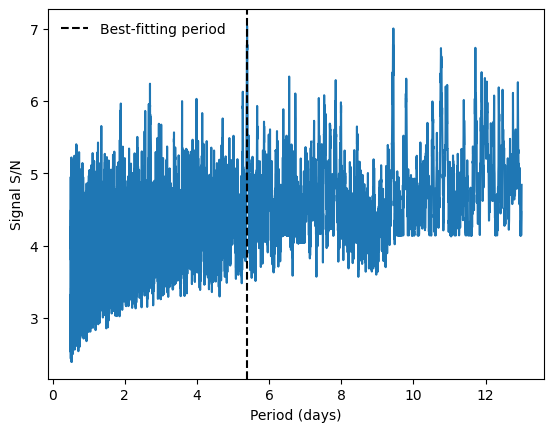

In [30]:
plt.plot(results.period, results.depth_snr)
plt.axvline(best_period, color='black', linestyle='--', label='Best-fitting period')
plt.xlabel('Period (days)')
plt.ylabel('Signal S/N')
plt.legend(frameon=False)

In [31]:
results['depth'][np.argmax(results.power)]

10.70715628772241

Awesome! We see that there is a clear peak in the signal-to-noise function. That is, we found a potential planetary signal in our data.

Let's do a little more digging with respect to that peak signal. First, we can see how well a sinusoid fits the data. If the "harmonic_delta_log_likelihood" is greater than 0, a sinusoid better fits the data than a transit — so we likely have not detected a true planetary signal.

In [34]:
max_power = np.argmax(results.power)
stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])
harmonic_delta_log_likelihood = stats['harmonic_delta_log_likelihood']
harmonic_delta_log_likelihood

-21.41700993186987

Great! It seems like our transit model is preferred, so we've passed this false positive check.

Another check that we can run is odd vs. even transit depths. A planet orbiting a star is expected to have the same transit depth every time (ignoring measurement uncertainty). Some false positive scenarios, however, have different depths for odd and even "transits." For two binary stars orbiting a common barycenter, however, the smaller star occulting the larger one produces a small "transit," whereas the larger one occulting the smaller one produces a large "transit." Testing for even/odd transit depth differences is therefore another important false positive check.

In [36]:
odd_depth, odd_depth_err = stats['depth_odd']
even_depth, even_depth_err = stats['depth_even']
combined_err = np.sqrt(odd_depth_err**2 + even_depth_err**2)
np.abs(odd_depth - even_depth), combined_err

(2.888178843371861, 3.2249214809817883)

The absolute difference between the odd and even depth is smaller than the combined error on the depths, so we can say that the data do not indicate a difference between odd and even transit events. We've passed another false positive test!

As a final false positive test for this notebook, let's reject transits that are "too big." Hot Jupiters orbiting Sun-like stars shouldn't have very large transit depths (for instance, > 30%), so let's check that the transit that we found is relatively shallow.

In [38]:
depth = results.depth[max_power]
depth / np.median(flux) >= 0.3

False

Awesome! We've passed yet another false positive test.

It's important to note that a publication-ready planet detection pipeline will have even more stringent false positive tests. For the purposes of this notebook, however, this is a solid start.

Next, let's wrap this code in a function and apply it to all the selected planets. First, let's write a function that just runs the BLS algorithm and returns its outputs for a given time, flux, and flux error.

In [40]:
def do_bls(time, flux, flux_err):
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    return results, stats

Next, we'll add a simple *inversion test*. This step flips the lightcurve and performs the same BLS search. The idea is that a true planetary signal will not return significant BLS results after being inverted, whereas a false positive (like a variable star producing a sinusoidal lightcurve) *will* produce a signal after being inverted.

In [41]:
def do_inversion_test(time, flux, flux_err):
    inverted_flux = -1 * flux + 2* np.mean(flux)
    results, stats = do_bls(time, inverted_flux, flux_err)
    return results, stats

Now we can wrap this all up in a function to find planets based on their TICIDs.

In [42]:
def find_planet(ticid):
    """
    This is our main function to find a planet. We basically perform the box-least squares algorithm, 
    then do a simple inversion test.

    todo: make this searchable by ticid.
    """
    lightcurve_object = lightcurve_objects[ticid]
    time, flux, flux_err  = lightcurve_object.time_lc, lightcurve_object.pdcflux, lightcurve_object.pdcflux_err

    # time is just a nan if the target has no data
    if isinstance(time, float):
        return False, np.nan, np.nan, np.nan, np.nan


    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]
    model = BoxLeastSquares(time, flux, flux_err)
    # results = model.power(periods, t_dur)  # The second argument is the duration of the transit (in days)
    results =model.autopower(t_durs, minimum_period=lower_limit, maximum_period=upper_limit,
                         frequency_factor=150.,
                            minimum_n_transit=3)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    # check the sinusoid model
    harmonic_delta_log_likelihood = stats['harmonic_delta_log_likelihood']

    if harmonic_delta_log_likelihood > 0.:
        return False, np.nan, np.nan, np.nan, np.nan

    # test if odd / even differ by a factor of 10
    odd_depth, odd_depth_err = stats['depth_odd']
    even_depth, even_depth_err = stats['depth_even']
    combined_err = np.sqrt(odd_depth_err**2 + even_depth_err**2)
    if np.abs(odd_depth-even_depth) > 10 * combined_err:
        return False, np.nan, np.nan, np.nan, np.nan

    # reject transits that are too large to be a planet
    
    depth = results.depth[max_power]
    if depth / np.median(flux) >= 0.3: # conservatively, 30% occultation is pretty big
        return False, np.nan, np.nan, np.nan, np.nan
        
    if results.depth_snr[max_power] >= 10:

        # test for variability
        # inverted_results, inverted_stats = do_inversion_test(time, flux, flux_err)
        # if len(inverted_stats['transit_times']) < 2 or inverted_results.depth_snr[max_power] < 10:
        return True, model, results.period[max_power], results.transit_time[max_power], results.duration[max_power]

            
    return False, np.nan, np.nan, np.nan, np.nan

        

With our function ready to go, we can apply it to our catalog.

In [43]:
def process_star(catalog_id):
    is_planet, model, period, transit_time, duration = find_planet(catalog_id)
    if is_planet:
        return catalog_id, (model, period, transit_time, duration)
    return None

def find_planets_parallel(star_names, n_cores=4):
    potential_planets = {}
    
    with Pool(n_cores) as pool:
        # Use imap to maintain order and enable progress bar
        results = list(tqdm(
            pool.imap(process_star, star_names),
            total=len(star_names),
            position=0
        ))
        
        # Filter None results and build dictionary
        potential_planets = dict(filter(None, results))
    
    return potential_planets


potential_planets = find_planets_parallel(star_names)

100%|██████████| 531/531 [03:32<00:00,  2.50it/s]


Great! Let's quickly see how many planets our simple pipeline found.

In [48]:
len(potential_planets)

25

In [ ]:
# found_planets_values = np.array(list(found_planets.values()))
# found_planets_values = found_planets_values[np.isfinite(found_planets_values)]

# n_found_planets = np.sum(found_planets_values)
# n_found_planets

potential_planets

In [ ]:
# n_successfully_searched = len(found_planets_values)
# n_found_planets/n_successfully_searched

Let's take a quick look at one of our targets' lightcurves to assess whether it might be a false positive. We'll plot both the light curve and the "phase folded" lightcurve — the lightcurve but wrapped around according to its period.

In [50]:
# make a list of just the names of the targets that may have orbiting planets
potential_planet_ids = list(potential_planets.keys())
potential_planet_ids

['26860837',
 '408819542',
 '450082728',
 '63467057',
 '408618999',
 '397067580',
 '233437236',
 '252479260',
 '345585983',
 '363766517',
 '26993764',
 '415966360',
 '117611856',
 '127366047',
 '289161011',
 '28687351',
 '233602411',
 '93441465',
 '69814255',
 '181150051',
 '92396416',
 '278870306',
 '300024339',
 '461163196',
 '382467980']

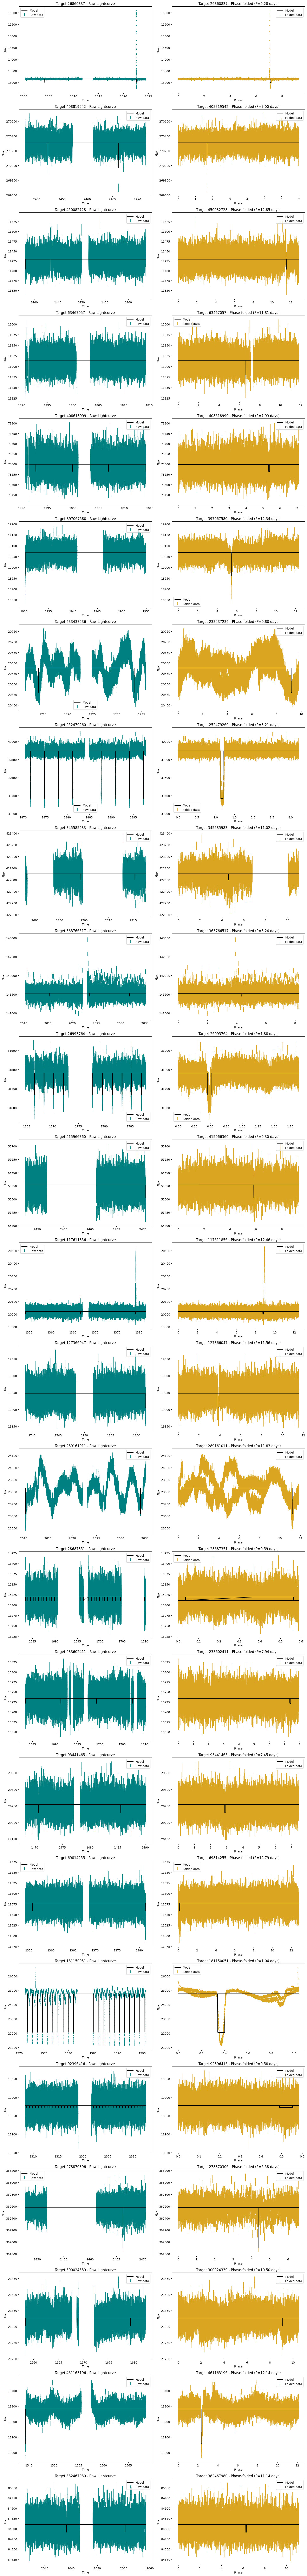

In [55]:
import matplotlib.pyplot as plt

def plot_target_lightcurves(lightcurve_objects, potential_planets, potential_planet_ids):
    """
    Plot lightcurves for each target showing both raw and phase-folded data.
    
    Parameters:
    -----------
    lightcurve_objects : dict
        Dictionary of lightcurve objects indexed by planet ID
    potential_planets : dict
        Dictionary containing (model, period, transit_time, duration) for each planet ID
    potential_planet_ids : list
        List of planet IDs to plot
    """
    # Create figure with 2 columns: raw and phase-folded
    fig = plt.figure(figsize=(15, 5 * len(potential_planet_ids)))
    
    for i, pid in enumerate(potential_planet_ids):
        # Get data for current target
        ob = lightcurve_objects[pid]
        model, period, transit_time, duration = potential_planets[pid]
        
        # Calculate model fluxes
        model_flux = model.model(ob.time_lc, period, duration, transit_time)
        model_flux_folded = model.model(ob.time_lc % period, period, duration, transit_time)
        
        # Create subplot for this target
        # Left plot: Raw lightcurve
        ax1 = plt.subplot(len(potential_planet_ids), 2, 2*i + 1)
        ax1.errorbar(ob.time_lc, ob.pdcflux, 
                    yerr=ob.pdcflux_err, 
                    fmt='.', color='teal', 
                    alpha=0.9, ms=1,
                    label='Raw data')
        ax1.plot(ob.time_lc, model_flux, 
                color='black', 
                zorder=100,
                label='Model')
        ax1.set_title(f'Target {pid} - Raw Lightcurve')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Flux')
        ax1.legend()
        
        # Right plot: Phase-folded lightcurve
        ax2 = plt.subplot(len(potential_planet_ids), 2, 2*i + 2)
        ax2.errorbar(ob.time_lc % period, ob.pdcflux, 
                    yerr=ob.pdcflux_err, 
                    fmt='.', color='goldenrod', 
                    alpha=0.9, ms=1,
                    label='Folded data')
        ax2.plot(ob.time_lc % period, model_flux_folded, 
                color='black', 
                zorder=100,
                label='Model')
        ax2.set_title(f'Target {pid} - Phase-folded (P={period:.2f} days)')
        ax2.set_xlabel('Phase')
        ax2.set_ylabel('Flux')
        ax2.legend()
    
    plt.tight_layout()
    return fig

# Usage:
fig = plot_target_lightcurves(lightcurve_objects, potential_planets, potential_planet_ids)
plt.show()

The above lightcurves indeed looks a bit messy. There's a decent chance that there is not a planetary signal within the data. So, a publication-ready planet detection / occurrence rate pipeline would certainly need to take more steps to flag these false positives.

For instance, consider the 7th row. The lightcurve has enough noise that the BLS algorithm incorrectly flagged a transit, and our false positive algorithms were not sufficiently sophisticated to reject this signal.

## About this notebook <a class="anchor" id="about_this_notebook"></a>


**Last updated:** Dec. 2024

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 